In [1]:
#!/usr/bin/env python
import getopt
import math
import numpy
import os
import PIL
import PIL.Image
import sys
import torch
import torch.utils.serialization

from utils import flow_inverse_warp

import cv2 
import os
import platform
import numpy as np
from copy import deepcopy
from skimage.io import imread
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

try:
    from correlation import correlation # the custom cost volume layer
except:
    sys.path.insert(0, './correlation'); from correlation import correlation  # you should consider upgrading python
# end

arguments_strModel = 'default'
arguments_strFirst = './images/first.png'
arguments_strSecond = './images/second.png'
arguments_strOut = './out.flo'
##########################################################
#assert(int(torch.__version__.replace('.', '')) >= 40) # requires at least pytorch version 0.4.0

torch.set_grad_enabled(False) # make sure to not compute gradients for computational performance

torch.cuda.device(1) # change this if you have a multiple graphics cards and you want to utilize them

torch.backends.cudnn.enabled = True # make sure to use cudnn for computational performance

##########################################################

# for strOption, strArgument in getopt.getopt(sys.argv[1:], '', [ strParameter[2:] + '=' for strParameter in sys.argv[1::2] ])[0]:
#     if strOption == '--model':
#         arguments_strModel = strArgument # which model to use

#     elif strOption == '--first':
#         arguments_strFirst = strArgument # path to the first frame

#     elif strOption == '--second':
#         arguments_strSecond = strArgument # path to the second frame

#     elif strOption == '--out':
#         arguments_strOut = strArgument # path to where the output should be stored

#     # end
# # end

##########################################################

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        class Extractor(torch.nn.Module):
            def __init__(self):
                super(Extractor, self).__init__()

                self.moduleOne = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
                    torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
                    torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1)
                )

                self.moduleTwo = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
                    torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
                    torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1)
                )

                self.moduleThr = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
                    torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
                    torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1)
                )

                self.moduleFou = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=2, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
                    torch.nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
                    torch.nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1)
                )

                self.moduleFiv = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3, stride=2, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
                    torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
                    torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1)
                )

                self.moduleSix = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=128, out_channels=196, kernel_size=3, stride=2, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
                    torch.nn.Conv2d(in_channels=196, out_channels=196, kernel_size=3, stride=1, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
                    torch.nn.Conv2d(in_channels=196, out_channels=196, kernel_size=3, stride=1, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1)
                )
            # end

            def forward(self, tensorInput):
                tensorOne = self.moduleOne(tensorInput)
                tensorTwo = self.moduleTwo(tensorOne)
                tensorThr = self.moduleThr(tensorTwo)
                tensorFou = self.moduleFou(tensorThr)
                tensorFiv = self.moduleFiv(tensorFou)
                tensorSix = self.moduleSix(tensorFiv)

                return [ tensorOne, tensorTwo, tensorThr, tensorFou, tensorFiv, tensorSix ]
            # end
        # end

        class Backward(torch.nn.Module):
            def __init__(self):
                super(Backward, self).__init__()
            # end

            def forward(self, tensorInput, tensorFlow):
                if hasattr(self, 'tensorPartial') == False or self.tensorPartial.size(0) != tensorFlow.size(0) or self.tensorPartial.size(2) != tensorFlow.size(2) or self.tensorPartial.size(3) != tensorFlow.size(3):
                    self.tensorPartial = tensorFlow.new_ones(tensorFlow.size(0), 1, tensorFlow.size(2), tensorFlow.size(3))
                # end

                if hasattr(self, 'tensorGrid') == False or self.tensorGrid.size(0) != tensorFlow.size(0) or self.tensorGrid.size(2) != tensorFlow.size(2) or self.tensorGrid.size(3) != tensorFlow.size(3):
                    tensorHorizontal = torch.linspace(-1.0, 1.0, tensorFlow.size(3)).view(1, 1, 1, tensorFlow.size(3)).expand(tensorFlow.size(0), -1, tensorFlow.size(2), -1)
                    tensorVertical = torch.linspace(-1.0, 1.0, tensorFlow.size(2)).view(1, 1, tensorFlow.size(2), 1).expand(tensorFlow.size(0), -1, -1, tensorFlow.size(3))

                    self.tensorGrid = torch.cat([ tensorHorizontal, tensorVertical ], 1).cuda()
                # end

                tensorInput = torch.cat([ tensorInput, self.tensorPartial ], 1)
                tensorFlow = torch.cat([ tensorFlow[:, 0:1, :, :] / ((tensorInput.size(3) - 1.0) / 2.0), tensorFlow[:, 1:2, :, :] / ((tensorInput.size(2) - 1.0) / 2.0) ], 1)

                tensorOutput = torch.nn.functional.grid_sample(input=tensorInput, grid=(self.tensorGrid + tensorFlow).permute(0, 2, 3, 1), mode='bilinear', padding_mode='zeros')

                tensorMask = tensorOutput[:, -1:, :, :]; tensorMask[tensorMask > 0.999] = 1.0; tensorMask[tensorMask < 1.0] = 0.0

                return tensorOutput[:, :-1, :, :] * tensorMask
            # end
        # end

        class Decoder(torch.nn.Module):
            def __init__(self, intLevel):
                super(Decoder, self).__init__()

                intPrevious = [ None, None, 81 + 32 + 2 + 2, 81 + 64 + 2 + 2, 81 + 96 + 2 + 2, 81 + 128 + 2 + 2, 81, None ][intLevel + 1]
                intCurrent = [ None, None, 81 + 32 + 2 + 2, 81 + 64 + 2 + 2, 81 + 96 + 2 + 2, 81 + 128 + 2 + 2, 81, None ][intLevel + 0]

                if intLevel < 6: self.moduleUpflow = torch.nn.ConvTranspose2d(in_channels=2, out_channels=2, kernel_size=4, stride=2, padding=1)
                if intLevel < 6: self.moduleUpfeat = torch.nn.ConvTranspose2d(in_channels=intPrevious + 128 + 128 + 96 + 64 + 32, out_channels=2, kernel_size=4, stride=2, padding=1)

                if intLevel < 6: self.dblBackward = [ None, None, None, 5.0, 2.5, 1.25, 0.625, None ][intLevel + 1]

                if intLevel < 6: self.moduleBackward = Backward()

                self.moduleCorrelation = correlation.Correlation(pad_size=4, kernel_size=1, max_displacement=4, stride1=1, stride2=1)
                self.moduleCorreleaky = torch.nn.LeakyReLU(inplace=False, negative_slope=0.1)
                self.moduleOne = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=intCurrent, out_channels=128, kernel_size=3, stride=1, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1)
                )

                self.moduleTwo = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=intCurrent + 128, out_channels=128, kernel_size=3, stride=1, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1)
                )

                self.moduleThr = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=intCurrent + 128 + 128, out_channels=96, kernel_size=3, stride=1, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1)
                )

                self.moduleFou = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=intCurrent + 128 + 128 + 96, out_channels=64, kernel_size=3, stride=1, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1)
                )

                self.moduleFiv = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=intCurrent + 128 + 128 + 96 + 64, out_channels=32, kernel_size=3, stride=1, padding=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1)
                )

                self.moduleSix = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=intCurrent + 128 + 128 + 96 + 64 + 32, out_channels=2, kernel_size=3, stride=1, padding=1)
                )
            # end

            def forward(self, tensorFirst, tensorSecond, objectPrevious):
                tensorFlow = None
                tensorFeat = None

                if objectPrevious is None:
                    tensorFlow = None
                    tensorFeat = None

                    tensorVolume = self.moduleCorreleaky(self.moduleCorrelation(tensorFirst, tensorSecond))

                    tensorFeat = torch.cat([ tensorVolume ], 1)

                elif objectPrevious is not None:
                    tensorFlow = self.moduleUpflow(objectPrevious['tensorFlow'])
                    tensorFeat = self.moduleUpfeat(objectPrevious['tensorFeat'])

                    tensorVolume = self.moduleCorreleaky(self.moduleCorrelation(tensorFirst, self.moduleBackward(tensorSecond, tensorFlow * self.dblBackward)))

                    tensorFeat = torch.cat([ tensorVolume, tensorFirst, tensorFlow, tensorFeat ], 1)

                # end

                tensorFeat = torch.cat([ self.moduleOne(tensorFeat), tensorFeat ], 1)
                tensorFeat = torch.cat([ self.moduleTwo(tensorFeat), tensorFeat ], 1)
                tensorFeat = torch.cat([ self.moduleThr(tensorFeat), tensorFeat ], 1)
                tensorFeat = torch.cat([ self.moduleFou(tensorFeat), tensorFeat ], 1)
                tensorFeat = torch.cat([ self.moduleFiv(tensorFeat), tensorFeat ], 1)

                tensorFlow = self.moduleSix(tensorFeat)

                return {
                    'tensorFlow': tensorFlow,
                    'tensorFeat': tensorFeat
                }
            # end
        # end

        class Refiner(torch.nn.Module):
            def __init__(self):
                super(Refiner, self).__init__()

                self.moduleMain = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=81 + 32 + 2 + 2 + 128 + 128 + 96 + 64 + 32, out_channels=128, kernel_size=3, stride=1, padding=1, dilation=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
                    torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=2, dilation=2),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
                    torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=4, dilation=4),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
                    torch.nn.Conv2d(in_channels=128, out_channels=96, kernel_size=3, stride=1, padding=8, dilation=8),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
                    torch.nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=1, padding=16, dilation=16),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
                    torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, dilation=1),
                    torch.nn.LeakyReLU(inplace=False, negative_slope=0.1),
                    torch.nn.Conv2d(in_channels=32, out_channels=2, kernel_size=3, stride=1, padding=1, dilation=1)
                )
            # end

            def forward(self, tensorInput):
                return self.moduleMain(tensorInput)
            # end
        # end

        self.moduleExtractor = Extractor()

        self.moduleTwo = Decoder(2)
        self.moduleThr = Decoder(3)
        self.moduleFou = Decoder(4)
        self.moduleFiv = Decoder(5)
        self.moduleSix = Decoder(6)

        self.moduleRefiner = Refiner()

        self.load_state_dict(torch.load('./models/' + arguments_strModel + '.pytorch'))
    # end

    def forward(self, tensorFirst, tensorSecond):
        tensorFirst = self.moduleExtractor(tensorFirst)
        tensorSecond = self.moduleExtractor(tensorSecond)

        objectEstimate = self.moduleSix(tensorFirst[-1], tensorSecond[-1], None)
        objectEstimate = self.moduleFiv(tensorFirst[-2], tensorSecond[-2], objectEstimate)
        objectEstimate = self.moduleFou(tensorFirst[-3], tensorSecond[-3], objectEstimate)
        objectEstimate = self.moduleThr(tensorFirst[-4], tensorSecond[-4], objectEstimate)
        objectEstimate = self.moduleTwo(tensorFirst[-5], tensorSecond[-5], objectEstimate)

        return objectEstimate['tensorFlow'] + self.moduleRefiner(objectEstimate['tensorFeat'])
    # end
# end

moduleNetwork = Network().cuda().eval()

##########################################################

def estimate(tensorFirst, tensorSecond):
    tensorOutput = torch.FloatTensor()
    batch_size = tensorFirst.size(0)
    assert(tensorFirst.size(2) == tensorSecond.size(2))
    assert(tensorFirst.size(3) == tensorSecond.size(3))

    intWidth = tensorFirst.size(3)
    intHeight = tensorFirst.size(2)

#     assert(intWidth == 1024) # remember that there is no guarantee for correctness, comment this line out if you acknowledge this and want to continue
#     assert(intHeight == 436) # remember that there is no guarantee for correctness, comment this line out if you acknowledge this and want to continue

    if True:
        tensorFirst = tensorFirst.cuda()
        tensorSecond = tensorSecond.cuda()
        tensorOutput = tensorOutput.cuda()
    # end

    if True:
#         tensorPreprocessedFirst = tensorFirst.view(1, 3, intHeight, intWidth)
#         tensorPreprocessedSecond = tensorSecond.view(1, 3, intHeight, intWidth)
        tensorPreprocessedFirst = tensorFirst
        tensorPreprocessedSecond = tensorSecond
        intPreprocessedWidth = int(math.floor(math.ceil(intWidth / 64.0) * 64.0))
        intPreprocessedHeight = int(math.floor(math.ceil(intHeight / 64.0) * 64.0))

        tensorPreprocessedFirst = torch.nn.functional.interpolate(input=tensorPreprocessedFirst, size=(intPreprocessedHeight, intPreprocessedWidth), mode='bilinear', align_corners=False)
        tensorPreprocessedSecond = torch.nn.functional.interpolate(input=tensorPreprocessedSecond, size=(intPreprocessedHeight, intPreprocessedWidth), mode='bilinear', align_corners=False)

        tensorFlow = 20.0 * torch.nn.functional.interpolate(input=moduleNetwork(tensorPreprocessedFirst, tensorPreprocessedSecond), size=(intHeight, intWidth), mode='bilinear', align_corners=False)

        tensorFlow[:, 0, :, :] *= float(intWidth) / float(intPreprocessedWidth)
        tensorFlow[:, 1, :, :] *= float(intHeight) / float(intPreprocessedHeight)

        tensorOutput.resize_(batch_size, 2, intHeight, intWidth).copy_(tensorFlow[:, :, :, :])
    # end

    if True:
        tensorFirst = tensorFirst.cpu()
        tensorSecond = tensorSecond.cpu()
        tensorOutput = tensorOutput.cpu()
    # end

    return tensorOutput
# end

##########################################################


In [2]:
if __name__ == '__main__':
        ################### 1.1 Path Setup
    ICDAR2013 = '/media/dragonx/DataLight/ICDAR2013/'
    ARC = '/media/dragonx/DataStorage/ARC/'
    if platform.uname()[1] != 'dragonx-H97N-WIFI':
        print("Now it knows it's in a remote cluster")
        ARC = '/work/cascades/lxiaol9/ARC/'
        ICDAR2013 = '/work/cascades/lxiaol9/ARC/EAST/data/ICDAR2013/'
    video_set = ['Video_11_4_1', 'Video_1_1_2', 'Video_17_3_1', 'Video_5_3_2', 'Video_6_3_2']
    seq = 'Video_52_7_4'
    video_name = '%strain/%s.mp4'%(ICDAR2013, seq)
    cap = cv2.VideoCapture(video_name)
    out_path = ICDAR2013 + 'vis/flow/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)

    index_ref = 100
    image_to_pair = range(-20, 20)
    cap.set(1, index_ref)
    ret, image2 = cap.read() 
    height, width = image2.shape[0:2]
    image2 = cv2.resize(image2, (512, 512))
    print(image2.shape)
    image_pairs = []
    flow_list = []
    wrapped_image_list = []
#     for i in range(0, 5):
#         index_frame = index_ref + image_to_pair[i]
#         cap.set(1, index_frame)
#         ret, image1 = cap.read() 
#         image1 = cv2.resize(image1, (512, 512))
#         image_pairs.append((image1, image2))
#         #img_pairs.append((cv2.resize(image1, (512, 512)), cv2.resize(image2, (512, 512))))
#         tensorFirst = torch.FloatTensor(numpy.array(image2)[np.newaxis, :, :, ::-1].transpose(0, 3, 1, 2).astype(numpy.float32) * (1.0 / 255.0))
#         tensorSecond = torch.FloatTensor(numpy.array(image1)[np.newaxis, :, :, ::-1].transpose(0, 3, 1,2).astype(numpy.float32) * (1.0 / 255.0))
#         print(tensorFirst.size())
#         print(tensorFirst.shape)
#         print(tensorSecond.size())
#         tensorOutput = estimate(tensorFirst, tensorSecond)
#         flow_list.append(tensorOutput)
    image1_batch = []
    image2_batch = []
    for i in range(0, 40):
        index_frame = index_ref + image_to_pair[i]
        cap.set(1, index_frame)
        ret, image1 = cap.read() 
        image1 = cv2.resize(image1, (512, 512))
        image1_batch.append(image1)
        image2_batch.append(image2)
    image1_4d = np.array(image1_batch)
    image2_4d = np.array(image2_batch)
    #img_pairs.append((cv2.resize(image1, (512, 512)), cv2.resize(image2, (512, 512))))
    tensorFirst = torch.FloatTensor(image2_4d.transpose(0, 3, 1, 2).astype(numpy.float32) * (1.0 / 255.0))
    tensorSecond = torch.FloatTensor(image1_4d.transpose(0, 3, 1,2).astype(numpy.float32) * (1.0 / 255.0))
    print(tensorFirst.size())
    print(tensorFirst.shape)
    print(tensorSecond.size())
    tensorOutput = estimate(tensorFirst, tensorSecond)
#     flow_list.append(tensorOutput)
    # running wrapping function 

Now it knows it's in a remote cluster
(512, 512, 3)
torch.Size([40, 3, 512, 512])
torch.Size([40, 3, 512, 512])
torch.Size([40, 3, 512, 512])


In [3]:
flow_list = []
flow_list.append(tensorOutput)
print(flow_list[0][1].size())

torch.Size([2, 512, 512])


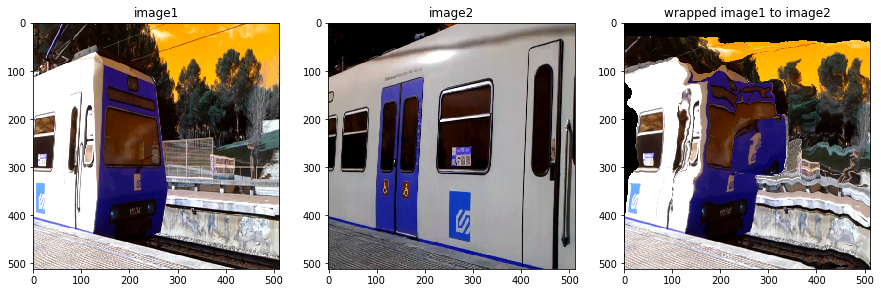

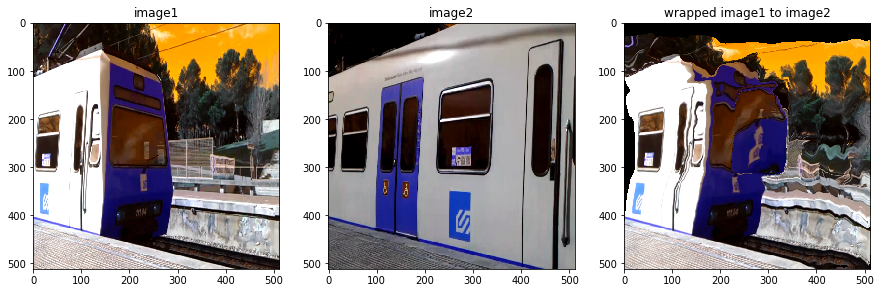

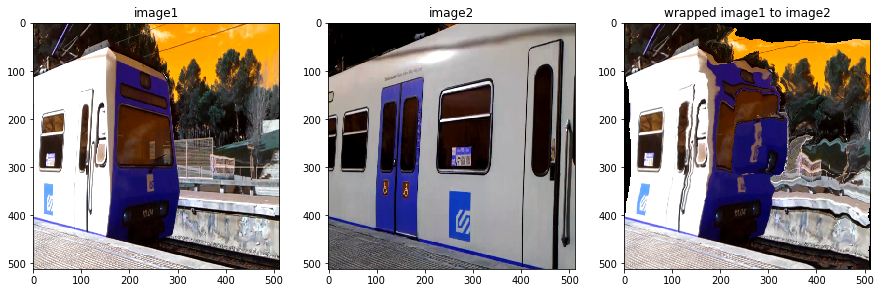

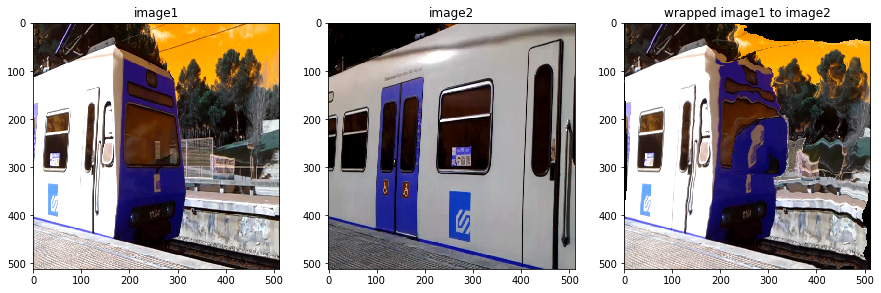

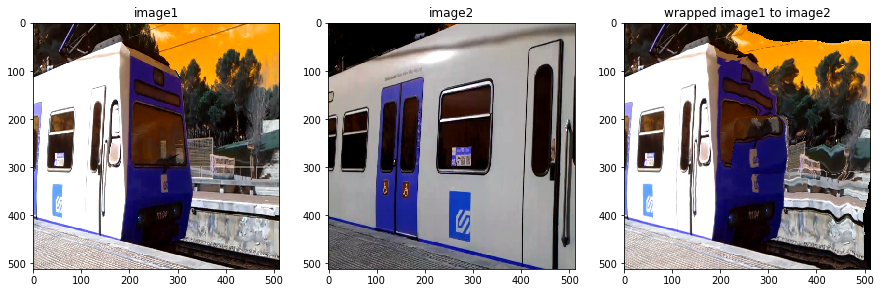

In [4]:
input_images = tf.placeholder(tf.float32, shape=[1,  512, 512, 3], name='input_images')
input_flow_maps = tf.placeholder(tf.float32, shape=[1, 512, 512, 2], name='input_flow_maps')
sess1 = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
image_wrapped = flow_inverse_warp(input_images, input_flow_maps)
wrapped_image_list = []
for i in range(5):
    wrapped_image = sess1.run(image_wrapped, feed_dict={input_images:image1_4d[i, :, :, :][np.newaxis],
                                                        input_flow_maps:flow_list[0][i].numpy().transpose(1, 2, 0)[np.newaxis, :, :, :]    })
    wrapped_image_list.append(wrapped_image)   
for j in range(5):
    plt.ion()
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(131, aspect='equal')
    ax1.set_title('image1')
    ax1.imshow(image1_4d[j])
    ax2 = fig.add_subplot(132, aspect='equal')
    ax2.set_title('image2')
    ax2.imshow(image2_4d[j])
    ax3 = fig.add_subplot(133, aspect='equal')
    ax3.set_title('wrapped image1 to image2')
    ax3.imshow(wrapped_image_list[j][0,:,:,:].astype(int))
# frame = 1
# fig.savefig(out_path+'frame{}.png'.format(frame))
#     import pdb;pdb.set_trace()

#     objectOutput = open(arguments_strOut, 'wb')

#     numpy.array([ 80, 73, 69, 72 ], numpy.uint8).tofile(objectOutput)
#     numpy.array([ tensorOutput.size(2), tensorOutput.size(1) ], numpy.int32).tofile(objectOutput)
#     numpy.array(tensorOutput.numpy().transpose(1, 2, 0), numpy.float32).tofile(objectOutput)

#     objectOutput.close()st[i].numpy().transpose(1, 2, 0)[np.newaxis, :, :, :]    })
    wrapped_image_list.append(wrapped_image)   
# # end

In [5]:
# import cv2 as cv
# cap = cv2.VideoCapture(video_name)
# ret, frame1 = cap.read()
# prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
# hsv = np.zeros_like(frame1)
# hsv[...,1] = 255
import cv2
pred_labels1 = []
wrapped_image_list1 = []

for i in range(5):
    flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(img_pairs[i][0],cv2.COLOR_BGR2GRAY),cv2.cvtColor(img_pairs[i][1],cv2.COLOR_BGR2GRAY), None, 0.5, 3, 15, 3, 5, 1.2, 0)
    pred_labels1.append(flow)
#     mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
#     hsv[...,0] = ang*180/np.pi/2
#     hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
#     bgr = cv.cvtColor(hsv,cv.COLOR_HSV2BGR)
#     plt.imshow('frame2',bgr)
#     k = cv.waitKey(30) & 0xff
#     if k == 27:
#         break
#     elif k == ord('s'):
#         cv.imwrite('opticalfb.png',frame2)
#         cv.imwrite('opticalhsv.png',bgr)
#     prvs = next
for i in range(5):
    wrapped_image = sess1.run(image_wrapped, feed_dict={input_images:img_pairs[i][0][np.newaxis, :, :, :],
                                                        input_flow_maps:pred_labels1[i][np.newaxis, :, :, :],
    })
    wrapped_image_list1.append(wrapped_image)   
for j in range(5):
    plt.ion()
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(131, aspect='equal')
    ax1.set_title('image1')
    ax1.imshow(img_pairs[j][0])
    ax2 = fig.add_subplot(132, aspect='equal')
    ax2.set_title('image2')
    ax2.imshow(img_pairs[j][1])
    ax3 = fig.add_subplot(133, aspect='equal')
    ax3.set_title('wrapped image1 to image2')
    ax3.imshow(wrapped_image_list1[j][0,:,:,:].astype(int))
cap.release()

NameError: name 'img_pairs' is not defined